## Rectangular waveguide - Discussion

In [5]:
import os
import sys
import fenics as fen
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import time

In [6]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))))
from rectangular_waveguide import RectangularWaveguide
import src.helpers as helpers
from src.vector_space import VectorSpaceL2

### Dimensions and properties

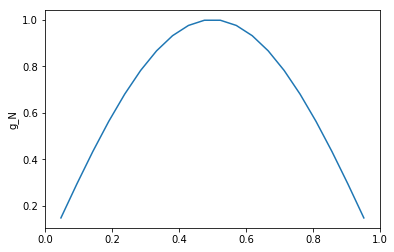

In [20]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
WG = RectangularWaveguide(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
WG.setup()
WG.plot_g_N()

### Solution of problem

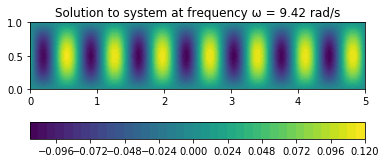

In [8]:
WG.solve(9.42)
WG.plot_solution()

In [21]:
class trace(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<WG.Ly

#VS = VectorSpaceL2(WG, trace())
VS = VectorSpaceL2(WG)

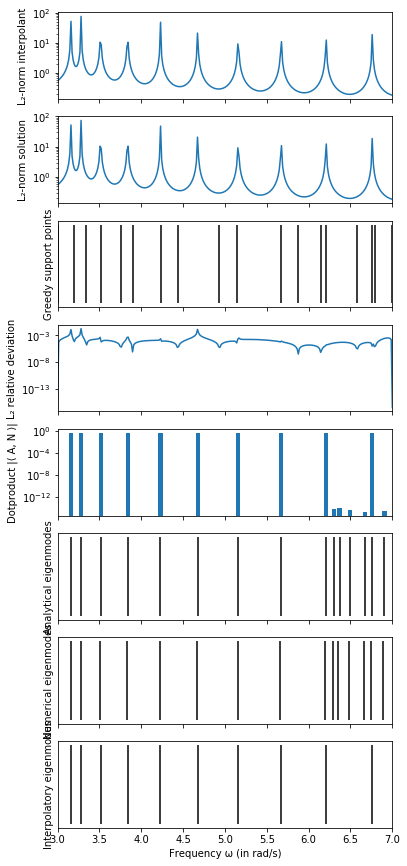

In [22]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 7
omegas = np.linspace(a, b, 300)

WG.compute_greedy_surrogate(VS, a, b, tol=1e-1, n=1000)
helpers.plot_surrogate_norms(ax[0], WG, omegas, VS)

WG.solve(omegas)
helpers.plot_solution_norms(ax[1], WG, VS)
helpers.plot_surrogate_support_points(ax[2], WG)
helpers.plot_surrogate_error_norms(ax[3], WG, VS)

helpers.plot_eigvecs_dot_N(ax[4], WG, a, b, width=0.05)
helpers.plot_numerical_eigenfrequencies(ax[5], WG, a, b)
helpers.plot_analytical_eigenfrequencies(ax[6], WG, a, b)
helpers.plot_interpolatory_eigenfrequencies(ax[7], WG, VS)

ax[0].set_ylabel('L\u2082-norm interpolant')
ax[1].set_ylabel('L\u2082-norm solution')
ax[2].set_ylabel('Greedy support points')
ax[2].set_yticks([])
ax[3].set_ylabel('L\u2082 relative deviation')
ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[5].set_ylabel('Analytical eigenmodes')
ax[5].set_yticks([])
ax[6].set_ylabel('Numerical eigenmodes')
ax[6].set_yticks([])
ax[7].set_ylabel('Interpolatory eigenmodes')
ax[7].set_yticks([])
ax[7].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[7].set_xlim(a, b)
plt.show()

### Timing

In [23]:
omega = WG.get_analytical_eigenfrequencies(0, 10)[0]

#### FEniCS solver

In [24]:
LHS = WG.get_K(tosparse=False) - omega**2 * WG.get_M(tosparse=False)
RHS = WG.get_L(tonumpy=False) + WG.get_N(tonumpy=False)
A_sol = fen.Function(WG.get_V())
%timeit fen.solve(LHS, A_sol.vector(), RHS)

17.3 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### SciPy sparse Hermitian eigenvalue solver

In [25]:
valid_indices = WG.get_valid_indices()
K = WG.get_K()[valid_indices, :][:, valid_indices]
M = WG.get_M()[valid_indices, :][:, valid_indices]
%timeit scipy.sparse.linalg.eigsh(K, k=1, M=M, sigma=omega**2)

46.1 ms ± 461 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Greedy surrogate

In [26]:
t0 = time.time()
WG.compute_greedy_surrogate(VS, a, b, tol=1e-3, n=1000)
time.time() - t0

0.7135043144226074

#### Standard surrogate with same nodes

In [27]:
t0 = time.time()
WG.solve(WG.RI.get_nodes())
WG.compute_surrogate(VS)
time.time() - t0

0.6789958477020264

### Compare methods

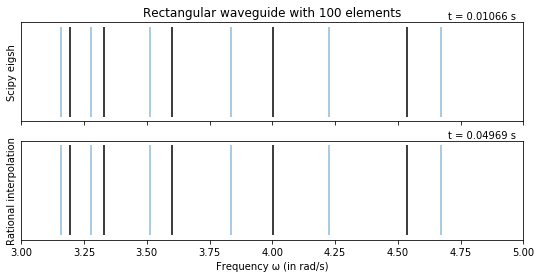

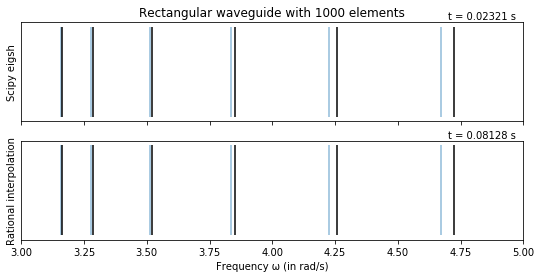

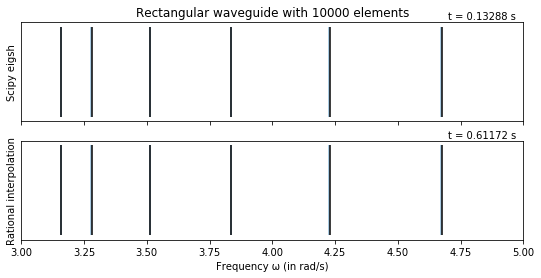

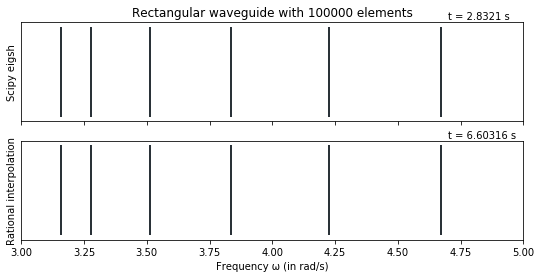

In [28]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5

for N in np.logspace(2, 5, 4, dtype=int):
    WG = RectangularWaveguide(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N)
    WG.setup()
    VS = VectorSpaceL2(WG)
    fig, ax = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    helpers.plot_analytical_eigenfrequencies(ax[0], WG, a, b, alpha=0.5, color='C0')
    t_FE = helpers.plot_numerical_eigenfrequencies(ax[0], WG, a, b, k=6, timer=True)
    helpers.plot_analytical_eigenfrequencies(ax[1], WG, a, b, alpha=0.5, color='C0')
    t0 = time.time()
    WG.compute_greedy_surrogate(VS, a, b, tol=1e-3, n=1000)
    helpers.plot_interpolatory_eigenfrequencies(ax[1], WG, VS)
    t_RI = time.time() - t0
    ax[0].set_title(f'Rectangular waveguide with {N} elements')
    ax[0].set_ylabel('Scipy eigsh')
    ax[0].text(0.85, 1.03, f't = {round(t_FE, 5)} s', transform=ax[0].transAxes)
    ax[0].set_yticks([])
    ax[1].set_ylabel('Rational interpolation')
    ax[0].text(0.85, 1.03, f't = {round(t_RI, 5)} s', transform=ax[1].transAxes)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
    ax[1].set_xlim(a, b)
    plt.show()